In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

import sys; sys.path.insert(0, '../')
import pickle as pkl
import numpy as np
from copy import deepcopy
import mne
import seaborn as sns
import matplotlib.pyplot as plt
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet import forward

plot_params = dict(surface='white', hemi='both', verbose=0)

# Forward Model

In [2]:
info = forward.get_info()
info['sfreq'] = 100
fwd = forward.create_forward_model(info=info)
fwd_free = forward.create_forward_model(info=info, fixed_ori=False)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

# Simulate

In [ ]:
n_samples = 10000

duration_of_trial = 1.0
settings = dict(duration_of_trial=duration_of_trial, method='standard')

sim_lstm = Simulation(fwd, info, verbose=True, settings=settings).simulate(n_samples=n_samples)
# sim_lstm.save(f'simulations/sim_{n_samples}_{int(duration_of_trial*100)}points.pkl')
# sim_lstm_prime = Simulation(fwd, info, verbose=True, settings=settings_prime).simulate(n_samples=2000)

# Load Simulations

In [ ]:
with open(r'simulations/sim_10000_100points_mixed.pkl', 'rb') as f:
    sim_lstm = pkl.load(f)

# Build & train LSTM network

In [ ]:
import tensorflow as tf
from esinet.losses import reg_loss
epochs = 150
patience = 10
activation_function = 'relu'
def combi(y_true, y_pred):
    error_1 = tf.keras.losses.CosineSimilarity()(y_true, y_pred)
    error_2 = tf.keras.losses.MeanSquaredError() (y_true, y_pred)
    return error_1 + error_2
loss = combi # 'mean_squared_error'
dropout = 0.2
optimizer = tf.keras.optimizers.Adam() #  'adam'  # tf.keras.optimizers.RMSprop(learning_rate=0.0001)

# Dense net
model_params = dict(activation_function=activation_function, n_dense_layers=2, 
    n_dense_units=200, n_lstm_layers=0, model_type='v2')
train_params = dict(epochs=epochs, patience=patience, tensorboard=True, 
    dropout=dropout, loss=loss, optimizer=optimizer, return_history=True,
    metrics=[tf.keras.losses.mean_squared_error], batch_size=8)
# Train
net_dense = Net(fwd, **model_params)
_, history_dense = net_dense.fit(sim_lstm, **train_params)
net_dense.model.compile(optimizer='adam', loss='mean_squared_error')
# LSTM v2
model_params = dict(activation_function=activation_function, n_lstm_layers=2, 
    n_lstm_units=60, n_dense_layers=0, 
    model_type='v2')
train_params = dict(epochs=epochs, patience=patience, tensorboard=True, 
    dropout=0.1, loss=loss, optimizer=optimizer, return_history=True,
    metrics=[tf.keras.losses.mean_squared_error], batch_size=8, device='/CPU:0')

# Train
net_lstm = Net(fwd, **model_params)
_, history_lstm = net_lstm.fit(sim_lstm, **train_params)
net_lstm.model.compile(optimizer='adam', loss='mean_squared_error')
models = [net_dense, net_lstm]
model_names = ['Dense', 'LSTM']
net_dense.save(r'models', name='dense-net-100points-noise-cosine')
net_lstm.save(r'models', name='lstm-net-100points-noise-cosine')

# Load Models

In [3]:
net_dense = util.load_net('models/dense-net-100points-noise-cosine_1')
net_lstm = util.load_net('models/lstm-net-100points-noise-cosine_0')
net_lstm_large = util.load_net('models/lstm-net-100points-noise-cosine-largemodels_1')

models = [net_dense, net_lstm, net_lstm_large]
model_names = ['Dense', 'LSTM', 'LSTM large']

# Plot single ground truth and predictions

In [4]:
import seaborn as sns
%matplotlib qt
sns.reset_orig()

%load_ext autoreload
%autoreload 2

plot_params = dict(surface='white', hemi='both', verbose=0, 
    clim=dict(kind='percent', pos_lims=[20, 30, 100]))

settings_eval = dict(duration_of_trial=1, method='standard', number_of_sources=3)
# settings_eval = dict(duration_of_trial=1, method='noise')

# Simulate new data
sim_test = Simulation(fwd, info, settings=settings_eval).simulate(1)
snr = sim_test.simulation_info['target_snr'].values[0]
# print(sim_test.simulation_info)
idx = 0
# Predict sources using the esinet models
predictions = [model.predict(sim_test) for model in models]
# Predict sources with classical methods
prediction_elor_data = util.wrap_mne_inverse(fwd, sim_test, snr=snr)[idx].data.astype(np.float32)
prediction_elor = deepcopy(predictions[0])
prediction_elor.data = prediction_elor_data / np.abs(np.max(prediction_elor_data))
prediction_mne_data = util.wrap_mne_inverse(fwd, sim_test, method='MNE', snr=snr)[idx].data.astype(np.float32)
prediction_mne = deepcopy(predictions[0])
prediction_mne.data = prediction_mne_data / np.abs(np.max(prediction_mne_data))
prediction_lcmv_data = util.wrap_mne_inverse(fwd_free, sim_test, method='beamformer', snr=snr)[idx].data.astype(np.float32)
prediction_lcmv = deepcopy(predictions[0])
prediction_lcmv.data = prediction_lcmv_data / np.abs(np.max(prediction_lcmv_data))
# Get predictions and names in order
predictions.append(prediction_elor)
predictions.append(prediction_mne)
predictions.append(prediction_lcmv)
model_names.append('eLORETA')
model_names.append('MNE')
model_names.append('Beamformer')

# Plot True Source
brain = sim_test.source_data[idx].plot(**plot_params)
brain.add_text(0.1, 0.9, f'Ground Truth {sim_test.simulation_info.number_of_sources.values[0]} sources, snr={snr:.1f}', 'title')
# Plot True EEG
evoked = sim_test.eeg_data[idx].average()
# evoked.plot()
evoked.plot_topomap(title='Ground Truth')
evoked = util.get_eeg_from_source(sim_test.source_data[idx], fwd, info, tmin=0.)
evoked.plot_topomap(title='Ground Truth Noiseless')

# Plot predicted sources
for model_name, prediction in zip(model_names, predictions):
    
    if not 'lstm' in model_name.lower() and not 'loreta' in model_name.lower():
        continue
    # try:
    error = util.batch_nmse(sim_test.source_data[idx].data, prediction.data)
    r = util.batch_corr(sim_test.source_data[idx].data, prediction.data)
    
    brain = prediction.plot(**plot_params)

    title = f'{model_name}, error: {error:.4}, r: {r}'
    brain.add_text(0.1, 0.9, title, 'title')
    # Plot predicted EEG
    evoked_esi = util.get_eeg_from_source(prediction, fwd, info, tmin=0.)
    # evoked_esi.plot()
    evoked_esi.plot_topomap(title=model_name)
    # except:
    #     pass

Simulating data based on sparse patches.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Simulate
n_samples = 5000
duration_of_trial = 1.0

settings = dict(duration_of_trial=duration_of_trial, method='noise')
sim_lstm_test = Simulation(fwd, info, verbose=False, settings=settings).simulate(n_samples=n_samples)
sim_lstm_test.save(f'simulations\\sim_test_{n_samples}_{int(duration_of_trial*100)}points_noise.pkl')
del sim_lstm_test

settings = dict(duration_of_trial=duration_of_trial, method='standard')
sim_lstm_test = Simulation(fwd, info, verbose=False, settings=settings).simulate(n_samples=n_samples)
sim_lstm_test.save(f'simulations\\sim_test_{n_samples}_{int(duration_of_trial*100)}points_standard.pkl')




## Or Load Evaluation Set

In [4]:
n_samples = 100
duration_of_trial = 0.1

settings = dict(duration_of_trial=duration_of_trial, method='standard')
sim_lstm_test = Simulation(fwd, info, verbose=False, settings=settings).simulate(n_samples=n_samples)
sim_lstm_test.save(f'simulations\\sim_test_{n_samples}_{int(duration_of_trial*100)}points_standard.pkl')

# or Load
# with open(f'simulations\\sim_test_{n_samples}_{int(duration_of_trial*100)}points_standard.pkl', 'rb') as f:
    # sim_lstm_test = pkl.load(f)

Simulating data based on sparse patches.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Calculate Evaluation Metrics

In [11]:
sim_lstm_test.source_data[0].plot(**plot_params)
pred_elor[0].plot(**plot_params)
pred_lcmv[0].plot(**plot_params)

Using control points [2.16947343e-08 2.34895611e-08 3.99513046e-08]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'
  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [1.52220746e-09 3.68442898e-09 1.07025087e-08]
Using control points [1.52220746e-09 3.68442898e-09 1.07025087e-08]
Using control points [1.15963941e-08 1.52831859e-08 4.88330109e-08]


In [12]:
from esinet.evaluate import eval_mean_localization_error, eval_nmse, eval_auc, eval_mse
from esinet.util import wrap_mne_inverse
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2
model_names = ['Dense', 'LSTM', 'LSTM large']
# Predict
print('predict esinets...')
predictions = [model.predict(sim_lstm_test) for model in models]

print('predict elor')
pred_elor = wrap_mne_inverse(fwd, sim_lstm_test, method='eLORETA')
model_names.append('eLORETA')
predictions.append(pred_elor)

print('predict MNE')
pred_mne = wrap_mne_inverse(fwd, sim_lstm_test, method='MNE')
model_names.append('MNE')
predictions.append(pred_mne)

print('predict LCMV')
pred_lcmv = wrap_mne_inverse(fwd_free, sim_lstm_test, method='beamformer')
model_names.append('LCMV')
predictions.append(pred_lcmv)

pos = util.unpack_fwd(fwd)[2]
argsorted_distance_matrix = np.argsort(cdist(pos, pos), axis=-1)

mean_localization_errors = []
aucs = []
nmses = []
mses = []
true_sources = np.stack([src.data for src in sim_lstm_test.source_data], axis=0)
true_sources = util.collapse(true_sources)

size = 500
n_total = true_sources.shape[0]
choice = np.random.choice(np.arange(n_total), size=size, replace=False)
# true_sources = true_sources[choice]
for prediction in tqdm(predictions):

    predicted_sources = util.collapse(np.stack([src.data for src in prediction], axis=0))
    print(predicted_sources.shape)
    # predicted_sources = predicted_sources[choice]
    print(predicted_sources.shape)
    print('mle calculation....')
    mean_localization_error = [eval_mean_localization_error(true_source, predicted_source, pos, argsorted_distance_matrix=argsorted_distance_matrix) for true_source, predicted_source in tqdm(zip(true_sources, predicted_sources))]
    auc = [eval_auc(true_source, predicted_source, pos, epsilon=0.25, n_redraw=25) for true_source, predicted_source in tqdm(zip(true_sources, predicted_sources))]
    nmse = [eval_nmse(true_source, predicted_source) for true_source, predicted_source in tqdm(zip(true_sources, predicted_sources))]
    mse = [eval_mse(true_source, predicted_source) for true_source, predicted_source in tqdm(zip(true_sources, predicted_sources))]
    
    mean_localization_errors.append(mean_localization_error)
    aucs.append(auc)
    nmses.append(nmse)
    mses.append(mse)

aucs_far = [auc[:, 1] for auc in np.array(aucs)]
aucs_close = [auc[:, 0] for auc in np.array(aucs)]

metrics = dict(
    mean_localization_errors=mean_localization_errors,
    aucs_far=aucs_far,
    aucs_close=aucs_close,
    nmses=nmses,
    mses=mses
)

with open(f'results\\metrics_{size}_{sim_lstm_test.source_data[0].data.shape[1]}points_standard.pkl', 'wb') as f:
    pkl.dump([metrics, choice], f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
predict esinets...
predict elor
predict MNE
predict LCMV


  0%|          | 0/6 [00:00<?, ?it/s]

(1000, 1284)
(1000, 1284)
mle calculation....


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1000, 1284)
(1000, 1284)
mle calculation....


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1000, 1284)
(1000, 1284)
mle calculation....


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1000, 1284)
(1000, 1284)
mle calculation....


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1000, 1284)
(1000, 1284)
mle calculation....


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1000, 1284)
(1000, 1284)
mle calculation....


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Load Metrics

In [ ]:
with open(f'results\\metrics_5000_100points_standard.pkl', 'rb') as f:
    [metrics, choice] = pkl.load(f)

# with open(f'simulations\\sim_test_5000_10points.pkl', 'rb') as f:
#     sim_lstm_test = pkl.load(f)


# Plot Evaluation Metrics

## Boxplot Overview 

In [13]:
model_names = ['Dense', 'LSTM', 'LSTM large', 'eLORETA', 'MNE', 'Beamformer']

In [14]:
import seaborn as sns; sns.set(style='whitegrid', font_scale=1.2, font='helvetica')
%matplotlib qt
xticks = dict(ticks=np.arange(len(model_names)), labels=model_names)
plot = sns.boxplot  # violinplot
variable_keys = metrics.keys()
names = [ 'Mean Localization Errors',  'Far area under the curve', 'Close area under the curve', 'Normalized Mean Squared Errors']
plt.figure(figsize=(14, 8))
    
subplot_nums = np.arange(221, 226)
for variable_key, name, num in zip(variable_keys, names, subplot_nums):
    plt.subplot(num)
    plot(data=metrics[variable_key])
    plt.title(name)
    plt.xticks(**xticks)
plt.tight_layout(pad=2)


mean_localization_errors: 	 14.82611513729512
aucs_far: 	 0.9137551490719701
aucs_close: 	 0.8315086915166967
nmses: 	 0.008207852
mses: 	 7.1979783e-20


[None, None, None, None, None]

In [54]:
import pandas as pd


,model_names,variable,value
2,LSTM large,mean_localization_errors,1.400919e+01
8,LSTM large,aucs_far,9.472964e-01
14,LSTM large,aucs_close,8.565780e-01
20,LSTM large,nmses,7.141386e-03
26,LSTM large,mses,4.359354e-20


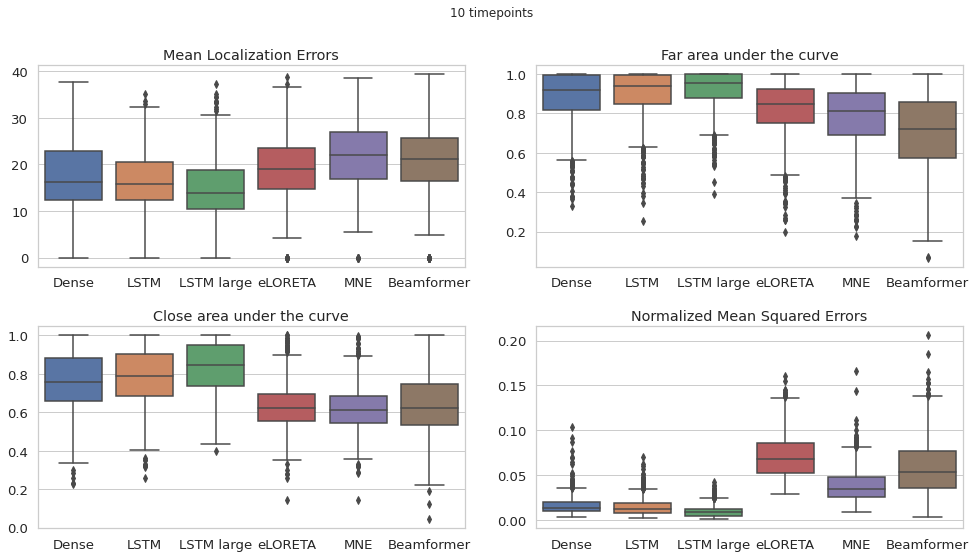

   model_names                  variable         value
2   LSTM large  mean_localization_errors  1.393005e+01
8   LSTM large                  aucs_far  9.566240e-01
14  LSTM large                aucs_close  8.437415e-01
20  LSTM large                     nmses  8.281106e-03
26  LSTM large                      mses  1.449341e-19
   model_names                  variable         value
0        Dense  mean_localization_errors  1.619252e+01
6        Dense                  aucs_far  9.192875e-01
12       Dense                aucs_close  7.571852e-01
18       Dense                     nmses  1.362083e-02
24       Dense                      mses  1.693042e-19


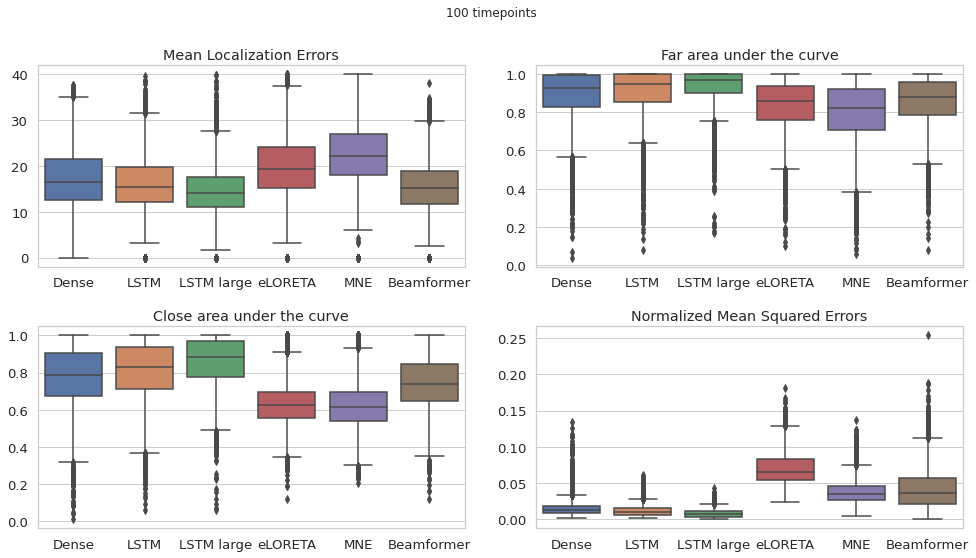

   model_names                  variable         value
2   LSTM large  mean_localization_errors  1.406056e+01
8   LSTM large                  aucs_far  9.684579e-01
14  LSTM large                aucs_close  8.821375e-01
20  LSTM large                     nmses  6.709087e-03
26  LSTM large                      mses  5.436120e-20
   model_names                  variable         value
0        Dense  mean_localization_errors  1.642246e+01
6        Dense                  aucs_far  9.277436e-01
12       Dense                aucs_close  7.852347e-01
18       Dense                     nmses  1.308777e-02
24       Dense                      mses  6.772048e-20


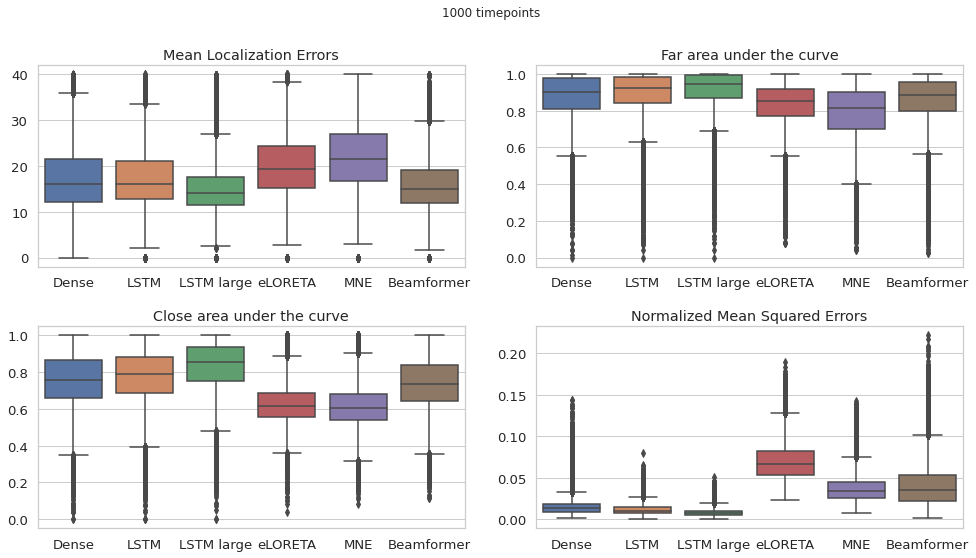

   model_names                  variable         value
2   LSTM large  mean_localization_errors  1.400919e+01
8   LSTM large                  aucs_far  9.472964e-01
14  LSTM large                aucs_close  8.565780e-01
20  LSTM large                     nmses  7.141386e-03
26  LSTM large                      mses  4.359354e-20
   model_names                  variable         value
0        Dense  mean_localization_errors  1.597388e+01
6        Dense                  aucs_far  9.043121e-01
12       Dense                aucs_close  7.566711e-01
18       Dense                     nmses  1.314916e-02
24       Dense                      mses  4.963057e-20


In [55]:
import seaborn as sns; sns.set(style='whitegrid', font_scale=1.2, font='helvetica')
%matplotlib inline
l = [10, 100, 1000]
for n in l:
    with open(f'results\\metrics_500_{n}points_standard.pkl', 'rb') as f:
        [metrics, choice] = pkl.load(f)

    df = pd.DataFrame(metrics, index=model_names)
    df['model_names'] = df.index
    df.index = np.arange(df.shape[0])

    df = df.melt(id_vars=["model_names"])
    df["value"] = [np.nanmedian(vals) for vals in df["value"].values]
    
    
    xticks = dict(ticks=np.arange(len(model_names)), labels=model_names)
    plot = sns.boxplot  # violinplot
    variable_keys = metrics.keys()
    names = [ 'Mean Localization Errors',  'Far area under the curve', 'Close area under the curve', 'Normalized Mean Squared Errors']
    a = plt.figure(figsize=(14, 8))
    subplot_nums = np.arange(221, 226)
    for variable_key, name, num in zip(variable_keys, names, subplot_nums):
        plt.subplot(num)
        plot(data=metrics[variable_key])
        plt.title(name)
        plt.xticks(**xticks)
    plt.suptitle(str(n) + " timepoints")
    plt.tight_layout(pad=2)
    
    plt.show()
    print(df[df["model_names"]=="LSTM large"])
    print(df[df["model_names"]=="Dense"])




## Quadratic Scatter

In [12]:
sns.set(style='whitegrid')

plt.figure(figsize=(12, 10))
subplot_nums = np.arange(221, 226)
inverse_idc = [4,2]
for variable_key, name, num in zip(variable_keys, names, subplot_nums):
    var = np.array(metrics[variable_key])[inverse_idc]
    var = var[:, ~np.isnan(var).any(axis=0)]
    if np.any(np.isnan(var)):
        print("still nans")

    plt.subplot(num)
    plt.scatter(var[0], var[1], edgecolors='k', s=2)
    # origin
    lo_lim = np.nanmin(var)
    hi_lim = np.nanmax(var)
    plt.plot([lo_lim, hi_lim], [lo_lim, hi_lim], '--r')

    prop_higher = np.sum(var[1] > var[0]) / len(var[0])
    cohens_d = (np.nanmean(var[0]) - np.nanmean(var[1])) / np.mean([np.nanstd(var[0]), np.nanstd(var[1])])
    median_diff = np.abs(np.nanmedian(var[0]-var[1]))
    title = f'{name} (higher in {100*prop_higher:.1f} %)\nmedian_difference: {median_diff}\ncohens d: {abs(cohens_d):.2f}'
    plt.title(title)
    plt.xlabel(model_names[inverse_idc[0]])
    plt.ylabel(model_names[inverse_idc[1]])
    
    # pad
    lo_lim -= abs(hi_lim-lo_lim)*0.05
    hi_lim += abs(hi_lim-lo_lim)*0.05
    
    # plot properties
    plt.xlim(lo_lim, hi_lim)
    plt.ylim(lo_lim, hi_lim)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

## Dependence on Noise

In [13]:
import pandas as pd
sns.set(font_scale=1.2, font='helvetica')
# pd.DataFrame( metrics , index=model_names)
stretched_indices = np.repeat(np.arange(sim_lstm_test.n_samples), sim_lstm_test.source_data[0].data.shape[1])
snr_bins = (0.5, 2, 4, 6, 8, 10)
# snr_bins = (0.5, 5, 10)

snr_bin_labels = [str(snr_bins[i]) + ' - ' + str(snr_bins[i+1]) for i in range(len(snr_bins)-1)]
params = list(sim_lstm_test.simulation_info.columns)
series = [sim_lstm_test.simulation_info.iloc[stretched_indices[choice]][param] for param in params]
df = pd.concat(series, axis=1)
df['target_snr_bins'] = np.digitize(df.target_snr, bins=snr_bins)
# df['avg_eccentricity'] = [np.median((df.positions.values[i]**2).sum(axis=1)**(1/2)) for i in range(df.shape[0])]
# df['avg_extent'] = [np.mean(df.extents.values[i]) for i in range(df.shape[0])]
# df['avg_beta'] = [np.mean(df.betas.values[i]) for i in range(df.shape[0])]

for i, model_name in enumerate(model_names):
    for metric_name, metric in metrics.items():
        col_name = model_name + '_' + metric_name

        df[col_name] = metric[i]

print(df.columns)
metric_names_nice = ['Mean Localization Error [mm]', 'AUC Far [%]', 'AUC Close [%]', 'Normalized Mean Squared Error', 'Mean Squared Error']
for metric_name, metric_name_nice in zip(metrics.keys(), metric_names_nice):
    df_temp = pd.concat((df.filter(regex='snr_'), df.filter(regex=metric_name)), axis=1).melt('target_snr_bins', var_name='cols', value_name='vals')
    g = sns.catplot(x='target_snr_bins', y='vals', hue='cols', capsize=.2, kind='point', data=df_temp)
    g.set(xticklabels=snr_bin_labels, ylabel=metric_name_nice, xlabel='Signal to Noise Ratio (SNR)')
    g._legend.remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

Index(['number_of_sources', 'positions', 'extents', 'amplitudes', 'shapes',
       'target_snr', 'betas', 'target_snr_bins',
       'Dense_mean_localization_errors', 'Dense_aucs_far', 'Dense_aucs_close',
       'Dense_nmses', 'Dense_mses', 'LSTM_mean_localization_errors',
       'LSTM_aucs_far', 'LSTM_aucs_close', 'LSTM_nmses', 'LSTM_mses',
       'LSTM large_mean_localization_errors', 'LSTM large_aucs_far',
       'LSTM large_aucs_close', 'LSTM large_nmses', 'LSTM large_mses',
       'eLORETA_mean_localization_errors', 'eLORETA_aucs_far',
       'eLORETA_aucs_close', 'eLORETA_nmses', 'eLORETA_mses',
       'MNE_mean_localization_errors', 'MNE_aucs_far', 'MNE_aucs_close',
       'MNE_nmses', 'MNE_mses', 'Beamformer_mean_localization_errors',
       'Beamformer_aucs_far', 'Beamformer_aucs_close', 'Beamformer_nmses',
       'Beamformer_mses'],
      dtype='object')


## Dependence on eccentricity

In [ ]:
import pandas as pd
sns.set(font_scale=1.2, font='helvetica')
# pd.DataFrame( metrics , index=model_names)
stretched_indices = np.repeat(np.arange(sim_lstm_test.n_samples), int(duration_of_trial*100))



params = list(sim_lstm_test.simulation_info.columns)
series = [sim_lstm_test.simulation_info.iloc[stretched_indices[choice]][param] for param in params]
df = pd.concat(series, axis=1)
df['avg_eccentricity'] = [np.median((df.positions.values[i]**2).sum(axis=1)**(1/2)) for i in range(df.shape[0])]
ecc_bins = np.linspace(int(df['avg_eccentricity'].values.min()), np.ceil(df['avg_eccentricity'].values.max()).astype(int), num=5)
ecc_bin_labels = [str(ecc_bins[i]) + ' - ' + str(ecc_bins[i+1]) for i in range(len(ecc_bins)-1)]
df['avg_eccentricity_bins'] = np.digitize(df['avg_eccentricity'].values, bins=ecc_bins)

df['avg_extent'] = [np.mean(df.extents.values[i]) for i in range(df.shape[0])]
df['avg_beta'] = [np.mean(df.betas.values[i]) for i in range(df.shape[0])]

for i, model_name in enumerate(model_names):
    for metric_name, metric in metrics.items():
        col_name = model_name + '_' + metric_name

        df[col_name] = metric[i]

print(df.columns)
dep_var_regex = 'avg_eccentricity_bins'  # 'target_snr_bins'
dep_var_label = 'Average eccentricity'  # 'Signal to Noise Ratio (SNR)'
metric_names_nice = ['Mean Localization Error [mm]', 'AUC Far [%]', 'AUC Close [%]', 'Normalized Mean Squared Error', 'Mean Squared Error']
for metric_name, metric_name_nice in zip(metrics.keys(), metric_names_nice):
    df_temp = pd.concat((df.filter(regex=dep_var_regex), df.filter(regex=metric_name)), axis=1).melt(dep_var_regex, var_name='cols', value_name='vals')
    g = sns.catplot(x=dep_var_regex, y='vals', hue='cols', capsize=.2, kind='point', data=df_temp)
    g.set(xticklabels=ecc_bin_labels, ylabel=metric_name_nice, xlabel=dep_var_label)
    g._legend.remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

## Dependence on No. of sources

In [ ]:
import pandas as pd
sns.set(font_scale=1.2, font='helvetica')
# pd.DataFrame( metrics , index=model_names)
stretched_indices = np.repeat(np.arange(sim_lstm_test.n_samples), int(duration_of_trial*100))

# nsrc_bins = (1, 2, 4, 8, 16, 20)
nsrc_bins = (1, 2, 4, 8, 10)

nsrc_bin_labels = [str(nsrc_bins[i]) + ' - ' + str(nsrc_bins[i+1]) for i in range(len(nsrc_bins)-1)]

params = list(sim_lstm_test.simulation_info.columns)
series = [sim_lstm_test.simulation_info.iloc[stretched_indices[choice]][param] for param in params]
df = pd.concat(series, axis=1)
df['number_of_sources_bins'] = np.digitize(df['number_of_sources'].values, bins=nsrc_bins)

for i, model_name in enumerate(model_names):
    for metric_name, metric in metrics.items():
        col_name = model_name + '_' + metric_name
        df[col_name] = metric[i]

print(df.columns)
dep_var_regex = 'number_of_sources_bins'  # 'target_snr_bins'
dep_var_label = 'Number of True Sources'  # 'Signal to Noise Ratio (SNR)'
metric_names_nice = ['Mean Localization Error [mm]', 'AUC Far [%]', 'AUC Close [%]', 'Normalized Mean Squared Error', 'Mean Squared Error']
for metric_name, metric_name_nice in zip(metrics.keys(), metric_names_nice):
    df_temp = pd.concat((df.filter(regex=dep_var_regex), df.filter(regex=metric_name)), axis=1).melt(dep_var_regex, var_name='cols', value_name='vals')
    g = sns.catplot(x=dep_var_regex, y='vals', hue='cols', capsize=.2, kind='point', data=df_temp)
    g.set(xticklabels=nsrc_bin_labels, ylabel=metric_name_nice, xlabel=dep_var_label)
    g._legend.remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

## Dependence on Beta

In [ ]:
import pandas as pd
sns.set(font_scale=1.2, font='helvetica')
# pd.DataFrame( metrics , index=model_names)
stretched_indices = np.repeat(np.arange(sim_lstm_test.n_samples), sim_lstm_test.source_data[0].data.shape[1])
snr_bins = (0.5, 2, 4, 6, 8, 10)
snr_bin_labels = [str(snr_bins[i]) + ' - ' + str(snr_bins[i+1]) for i in range(len(snr_bins)-1)]

beta_bins = (0.5, 0.75, 1, 1.25, 1.5)
beta_bin_labels = [str(beta_bins[i]) + ' - ' + str(beta_bins[i+1]) for i in range(len(beta_bins)-1)]


params = list(sim_lstm_test.simulation_info.columns)
series = [sim_lstm_test.simulation_info.iloc[stretched_indices[choice]][param] for param in params]
df = pd.concat(series, axis=1)
df['target_snr_bins'] = np.digitize(df.target_snr, bins=snr_bins)

df['avg_beta'] = [np.mean(df.betas.values[i]) for i in range(df.shape[0])]
df['avg_beta_bins']  = np.digitize(df.avg_beta, bins=beta_bins)


for i, model_name in enumerate(model_names):
    for metric_name, metric in metrics.items():
        col_name = model_name + '_' + metric_name

        df[col_name] = metric[i]

print(df.columns)
regex = 'beta_'
metric_names_nice = ['Mean Localization Error [mm]', 'AUC Far [%]', 'AUC Close [%]', 'Normalized Mean Squared Error', 'Mean Squared Error']
for metric_name, metric_name_nice in zip(metrics.keys(), metric_names_nice):
    df_temp = pd.concat((df.filter(regex=regex), df.filter(regex=metric_name)), axis=1).melt('avg_beta_bins', var_name='cols', value_name='vals')
    g = sns.catplot(x='avg_beta_bins', y='vals', hue='cols', capsize=.2, kind='point', data=df_temp)
    g.set(xticklabels=beta_bin_labels, ylabel=metric_name_nice, xlabel='Beta Exponent')
    g._legend.remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

## Dependence on Extent

In [ ]:
import pandas as pd
sns.set(font_scale=1.2, font='helvetica')
# pd.DataFrame( metrics , index=model_names)
stretched_indices = np.repeat(np.arange(sim_lstm_test.n_samples), sim_lstm_test.source_data[0].data.shape[1])

extent_bins = np.linspace(20, 40, 5)
extent_bin_labels = [str(int(round(extent_bins[i]))) + ' - ' + str(int(round(extent_bins[i+1]))) for i in range(len(extent_bins)-1)]

params = list(sim_lstm_test.simulation_info.columns)
series = [sim_lstm_test.simulation_info.iloc[stretched_indices[choice]][param] for param in params]
df = pd.concat(series, axis=1)

df['avg_extent'] = [np.mean(df.extents.values[i]) for i in range(df.shape[0])]
df['avg_extent_bins']  = np.digitize(df.avg_extent, bins=extent_bins)


for i, model_name in enumerate(model_names):
    for metric_name, metric in metrics.items():
        col_name = model_name + '_' + metric_name

        df[col_name] = metric[i]

print(df.columns)
regex = 'extent_'
metric_names_nice = ['Mean Localization Error [mm]', 'AUC Far [%]', 'AUC Close [%]', 'Normalized Mean Squared Error', 'Mean Squared Error']
for metric_name, metric_name_nice in zip(metrics.keys(), metric_names_nice):
    df_temp = pd.concat((df.filter(regex=regex), df.filter(regex=metric_name)), axis=1).melt('avg_extent_bins', var_name='cols', value_name='vals')
    g = sns.catplot(x='avg_extent_bins', y='vals', hue='cols', capsize=.2, kind='point', data=df_temp)
    g.set(xticklabels=extent_bin_labels, ylabel=metric_name_nice, xlabel='Source extent [mm]')
    g._legend.remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

## Save all figures

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def multipage(filename, figs=None, dpi=300, png=False):
    ''' Saves all open (or list of) figures to filename.pdf with dpi''' 
    pp = PdfPages(filename)
    path = os.path.dirname(filename)
    fn = os.path.basename(filename)[:-4]

    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for i, fig in enumerate(figs):
        print(f'saving fig {fig}\n')
        fig.savefig(pp, format='pdf', dpi=dpi)
        if png:
            fig.savefig(f'{path}\\{i}_{fn}.png', dpi=600)
    pp.close()

multipage(f'figures\\figs_5000_10samples\\figs_5000_10samples.pdf', png=True)

In [ ]:
import seaborn as sns
%matplotlib qt
model_names[0] = 'Dense'

data = {model_name: nmse for model_name, nmse in zip(model_names, nmses)}
plt.figure()
sns.kdeplot(data=data, multiple='stack')
plt.title('Normalized Mean Squared Errors')

plt.figure()
data = {model_name: mse for model_name, mse in zip(model_names, mses)}
sns.kdeplot(data=data, multiple='stack')
plt.title('Mean Squared Errors')


plt.figure()
data = {model_name: auc for model_name, auc in zip(model_names, aucs_far)}
sns.kdeplot(data=data, multiple='stack')
plt.title('Far area under the curve')


plt.figure()
data = {model_name: auc for model_name, auc in zip(model_names, aucs_close)}
sns.kdeplot(data=data, multiple='stack')
plt.title('Close area under the curve')

plt.figure()
data = {model_name: mle for model_name, mle in zip(model_names, mean_localization_errors)}
sns.kdeplot(data=data, multiple='stack')
plt.title('Close area under the curve')
plt.title('Mean Localization Errors')

plt.tight_layout()

# Performance per Difficulty Evaluation

In [ ]:
metrics = [nmses, mean_localization_errors, aucs_far, aucs_close]
metric_names = ['nmses', 'mean_localization_errors', 'aucs_far', 'aucs_close']

covariates = ['target_snr', 'number_of_sources']

n_samples = int(np.array(nmses).shape[1] / 20)
for covariate in covariates:
    sim_params = sim_lstm_test.simulation_info[covariate].values[:n_samples]
    sim_params = np.repeat(sim_params, 20)
    for metric, metric_name in zip(metrics, metric_names):
        plt.figure()
        for i, model_name in enumerate(model_names):
            plt.scatter(sim_params, metric[i], label=model_name, s=.7)
        plt.title(f'{covariate}, {metric_name}')
        plt.legend()


## Speed test

In [ ]:
import time

def new_sim_params(sr=100, packages_per_second=20):
    package_size = int( round( sr / packages_per_second  ) )
    package_interval = package_size/sr

    n_chan = len(sim_lstm_test.eeg_data.ch_names)
    data_package = np.random.randn(n_chan, package_size)

    sim_data_package = Simulation(fwd, info, settings=dict(duration_of_trial=0.01*package_size)).simulate(1)
    print(f'performing predictions {packages_per_second} times per second')

    return sim_data_package, package_interval

packages_per_second = 50
sim_data_package, package_interval = new_sim_params(packages_per_second=packages_per_second)

while True:
    start = time.time()
    # stc = net_dense.predict(sim_data_package)
    stc = net_lstm.predict(sim_data_package)

    stop = time.time()
    diff = stop-start
    if stop-start > package_interval:
        print(f"took longer than expected: {diff} (instead of {package_interval})")
        print(f'decreasing package interval by one')
        packages_per_second -= 1
        sim_data_package, package_interval = new_sim_params(packages_per_second=packages_per_second)
        print(f'packages_per_second={packages_per_second}\n')
        continue
    time.sleep(package_interval-diff)

